In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from matplotlib import patches
from matplotlib.collections import PatchCollection
import pandas as pd
import torchaudio
import torchaudio.transforms as T
import librosa

/home/s1918275/.local/lib/python3.8/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
ann_path = 'annotations/BritishBatCalls_MartynCooke_2018_1_sec_train_expert.json'

audio_dir = 'example_audio/bat_data_martyn_2018/'
#file_of_interest = 'PipPip_D-20180620_214356-Pippip_0_1.0.wav'
file_of_interest = 'BARBAR_20180723_215600-BARBAR-LR_0_1.0.wav'

## Helper functions

In [44]:
def gen_mag_spectrogram(x, nfft, noverlap):
    # Computes magnitude spectrogram by specifying time.

    # window data
    step = nfft - noverlap
    shape = (nfft, (x.shape[-1]-noverlap)//step)
    strides = (x.strides[0], step*x.strides[0])
    x_wins = np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

    # apply window
    x_wins = np.hanning(x_wins.shape[0]).astype(np.float32)[..., np.newaxis] * x_wins

    # do fft
    # note this will be much slower if x_wins.shape[0] is not a power of 2
    complex_spec = np.fft.rfft(x_wins, axis=0)

    # calculate magnitude
    #spec = (np.conjugate(complex_spec) * complex_spec).real
    # same as:
    spec = np.absolute(complex_spec)**2

    # orientate the ocrrect way 
    spec = np.flipud(spec)
  
    # convert to "amplitude"
    spec = np.log(1.0 + spec)

    return spec

def plot_bounding_box_patch(ann, freq_scale, colors):
    patch_collect = []
    for aa in ann['annotation']:
        xx = aa['start_time']
        ww = aa['end_time'] - aa['start_time']
        yy = aa['low_freq'] / freq_scale
        hh = (aa['high_freq'] - aa['low_freq']) / freq_scale
        col = colors[int(aa['individual'])]
        patch_collect.append(patches.Rectangle((xx, yy), ww, hh, linewidth=1,
                             edgecolor=col, facecolor='none', alpha=1.0))
    return patch_collect


def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    fig.set_size_inches(20, 10)
    plt.show(block=False)


## Load annocations

In [4]:
data = json.load(open(ann_path))

df = pd.json_normalize(data, record_path=['annotation'], meta=['id'])

In [5]:
duration = df['end_time'] - df['start_time']

df['duration'] = duration

df.describe()

,end_time,high_freq,low_freq,start_time,duration
count,6242.000000,6242.000000,6242.000000,6242.000000,6242.000000
mean,0.496609,82591.596853,44101.257813,0.484339,0.012270
std,0.285968,25129.398756,20204.163371,0.285923,0.015195
min,0.006974,21748.535156,15625.000000,0.001799,0.001805
25%,0.251055,61523.437500,28320.312500,0.238316,0.004937
50%,0.493318,84000.000000,35644.531250,0.480982,0.006172
75%,0.742767,104478.149414,53710.937500,0.729807,0.008641
max,0.999875,150666.666667,147333.333333,0.996531,0.102865


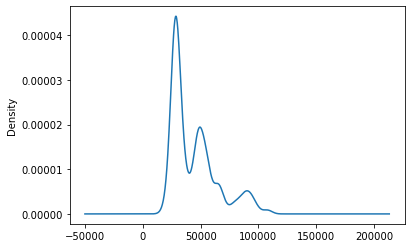

In [6]:
df['low_freq'].plot(kind='kde')

In [13]:
# load annotations
data = json.load(open(ann_path))
data_dict = {}
for dd in data:
    data_dict[dd['id']] = dd
ann = data_dict[file_of_interest]

# load audio file
# return sample rate and data
fs, x = wavfile.read(audio_dir + file_of_interest)
duration = x.shape[0]/fs

# generate spectrogram
spec = gen_mag_spectrogram(x, 1024, 840)

# unit = fs/2/spec.shape[0]
# startP = int(10000/unit)
# endP = int(140000/unit) + 1

# spec = spec[startP:endP]

# means = np.mean(spec, axis = 1)

# for i in range(len(means)):
#     spec[i] = np.maximum(spec[i] - means[i] , 0)
    


print(spec.shape)

# print status
print('File Name:', ann['id'])
print('Number of Events:', len(ann['annotation']))
print('sampling rate', fs)
print('duration (seconds)', duration)
print('\n')

(513, 1625)
File Name: BARBAR_20180723_215600-BARBAR-LR_0_1.0.wav
Number of Events: 5
sampling rate 300000
duration (seconds) 1.0




<ipython-input-11-19a29dc03f60>:1: FutureWarning: Pass sr=300000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = librosa.pcen(spec, fs)


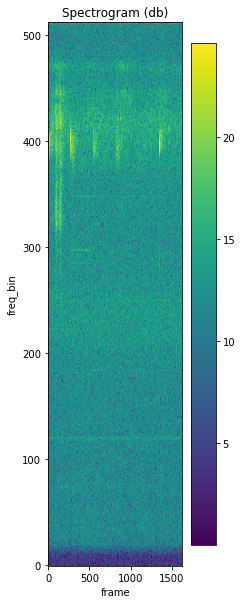

In [32]:
spec = gen_mag_spectrogram(x, 1024, 840)
plot_spectrogram(spec)

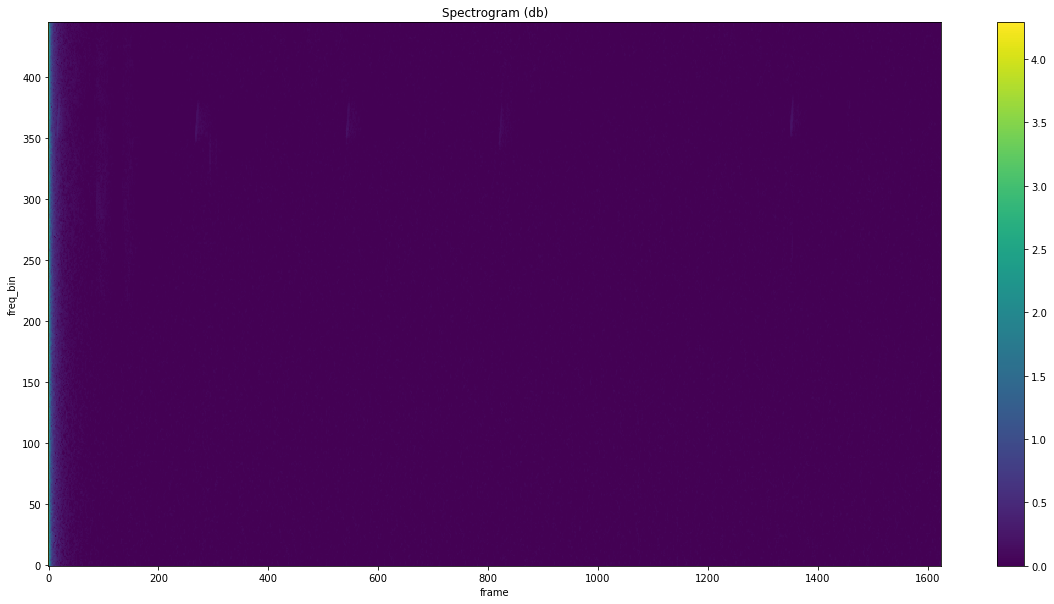

In [45]:
spec2 = spec
unit = fs/2/spec2.shape[0]
startP = int(10000/unit)
endP = int(140000/unit) + 1

spec2 = spec2[startP:endP]



spec2 = librosa.pcen(spec2* (2**31), sr=300000/10).astype(np.float32)

means = np.mean(spec2, axis = 1)

for i in range(len(means)):
    spec2[i] = np.maximum(spec2[i] - means[i] , 0)
    
plot_spectrogram(spec2)

## Calculate trim time

In [98]:

trimInTime = []
trimOutTime = []

for index, row in df.iterrows():
    startTime = row['start_time']
    endTime   = row['end_time']
    middleTime = (endTime + startTime) / 2
    if(middleTime - 0.01 > 0):
        trimInTime.append(middleTime - 0.01)
        trimOutTime.append(middleTime + 0.01)
    else:
        trimInTime.append(0)
        trimOutTime.append(0.02)
        
df['trimInTime'] = trimInTime
df['trimOutTime'] = trimOutTime

df.describe()

,end_time,high_freq,low_freq,start_time,duration,trimInTime,trimOutTime
count,6242.000000,6242.000000,6242.000000,6242.000000,6242.000000,6242.000000,6242.000000
mean,0.496609,82591.596853,44101.257813,0.484339,0.012270,0.480497,0.500497
std,0.285968,25129.398756,20204.163371,0.285923,0.015195,0.285806,0.285806
min,0.006974,21748.535156,15625.000000,0.001799,0.001805,0.000000,0.020000
25%,0.251055,61523.437500,28320.312500,0.238316,0.004937,0.235054,0.255054
50%,0.493318,84000.000000,35644.531250,0.480982,0.006172,0.477763,0.497763
75%,0.742767,104478.149414,53710.937500,0.729807,0.008641,0.726078,0.746078
max,0.999875,150666.666667,147333.333333,0.996531,0.102865,0.988177,1.008177


## Trim the data

In [140]:
type(spec)

numpy.ndarray

In [146]:
trimmed_data = []

for index, row in df[df['id'] == file_of_interest].iterrows():
    startNum = int(row['trimInTime']/duration * spec.shape[0])
    endNum   = int(row['trimOutTime']/duration * spec.shape[0])
    
    trimmed_data.append(spec[0:spec.shape[0],startNum:endNum])
#     tData = []
#     for row in spec:
#         tData.append(row[startNum:endNum])
#     trimmed_data.append(tData)


trimmed_data[0].shape


(513, 11)

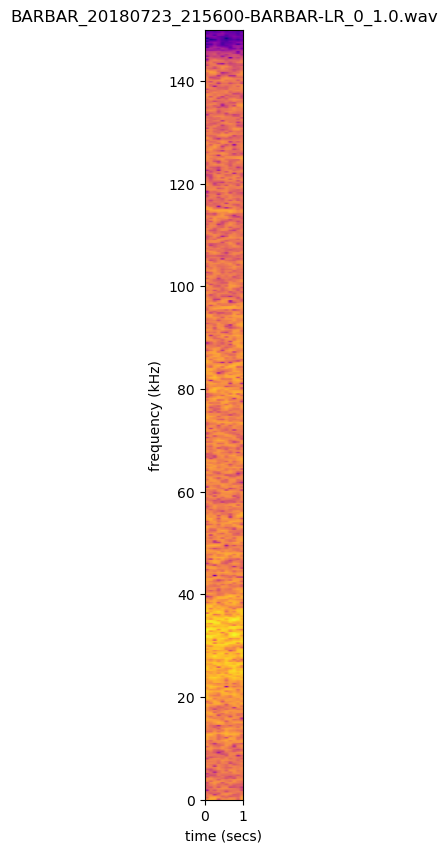

In [155]:
# parameters
freq_scale = 1000  # turn Hz in kHz
min_freq = 0
max_freq = fs /2 
colors = ['w', 'r', 'g', 'k', 'y', 'c', 'm']

# setup plot
plt.close('all')
plt.figure(0, figsize=(0.5,10))
plt.title(ann['id'])
plt.xlabel('time (secs)')
plt.ylabel('frequency (kHz)')

# plot the spectrogram
ax = plt.gca()
# extend is the size for bounding box of the image
y_extent = [0, duration, min_freq//freq_scale, max_freq//freq_scale]
ax.imshow(trimmed_data[1], aspect='auto', cmap='plasma', extent=y_extent)

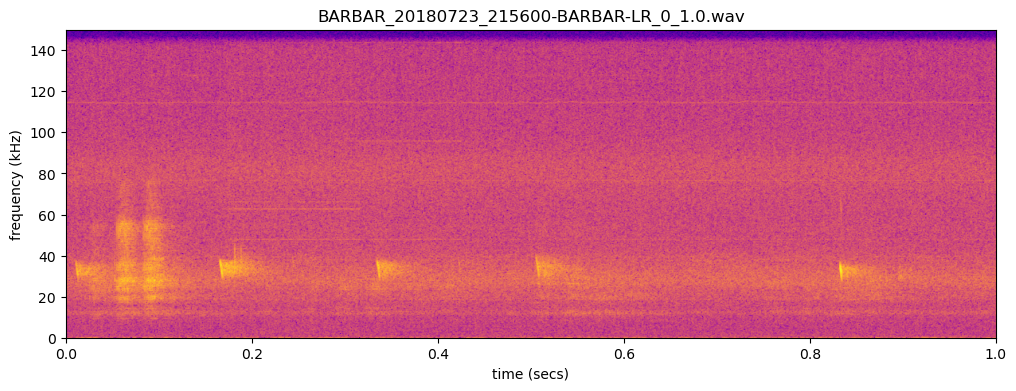

In [152]:
# parameters
freq_scale = 1000  # turn Hz in kHz
min_freq = 0
max_freq = fs /2 
colors = ['w', 'r', 'g', 'k', 'y', 'c', 'm']

# setup plot
plt.close('all')
plt.figure(0, figsize=(12,4))
plt.title(ann['id'])
plt.xlabel('time (secs)')
plt.ylabel('frequency (kHz)')

# plot the spectrogram
ax = plt.gca()
# extend is the size for bounding box of the image
y_extent = [0, duration, min_freq//freq_scale, max_freq//freq_scale]
ax.imshow(spec, aspect='auto', cmap='plasma', extent=y_extent)